In [183]:
import cv2
import os #read all files and return a list of files. Make for loop or dply in R. Specify colum(selct only what I need)
import argparse
import numpy as np
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv


In [184]:
# INPUT VARIABLES
## The options class mimics the workflow command-line argument parser that is used for workflow 
## parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.
class options:
    def __init__(self):
        # Input image path/filename
        #self.image = "./Lettuce3/imgs/2023-06-16-10-00-02_imx708_wide_rep1_2-2_9.jpg"
        self.image='C:/Users/mi79012/OneDrive - University of Georgia//Pi/test scripts/2023-06-16-10-00-02_imx708_wide_rep1_2-2_9 - Copy.jpg'
        # Debug mode = None, "plot", or "print"
        self.debug = "plot"
        # Store output images (True/False)
        self.writeimg = True
        # Results path/filename
        #self.result = "./Lettuce3/imgs/1.csv"
        self.result='C:/Users/mi79012/OneDrive - University of Georgia//Pi/test scripts/result.csv'
        # Image output directory path
        #self.outdir = "./Lettuce3/imgs"
        self.outdir='C:/Users/mi79012/OneDrive - University of Georgia//Pi/test scripts'
        
        
#         # Add a method to clear measurements
#     def clear(self):
#             self.measurements = {}
#             self.images = [false]
            #self.observations = {}
        
## args holds the input variables
args = options()
## Set debug to the global parameter
pcv.params.debug = args.debug

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 20
pcv.params.text_thickness = 10

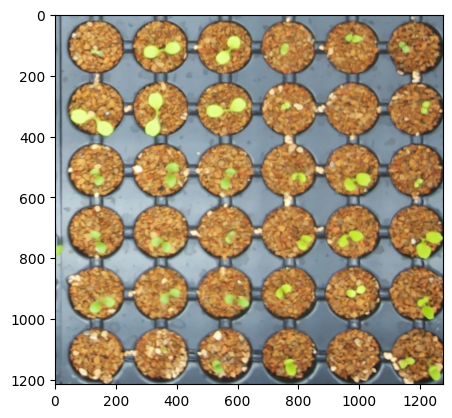

In [185]:
#for jpg
#directory ='C:/Users/mi79012/OneDrive - University of Georgia//Pi/test scripts/2023-06-16-10-00-02_imx708_wide_rep1_2-2_9 - Copy.jpg'


#for png
#directory ='C:/Users/mi79012/OneDrive - University of Georgia//Pi/test scripts/10_23-11-21-20-00-01 - Copy.png'
img, path, filename = pcv.readimage(filename=args.image)#img, path, filename = pcv.readimage(filename=directory, mode='BGR')

#cv2
#img = cv2.imread(directory)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.imread(directory, cv2.IMREAD_COLOR)
#img = cv2.imread(directory, cv2.IMREAD_UNCHANGED)
#plt.imshow(img)


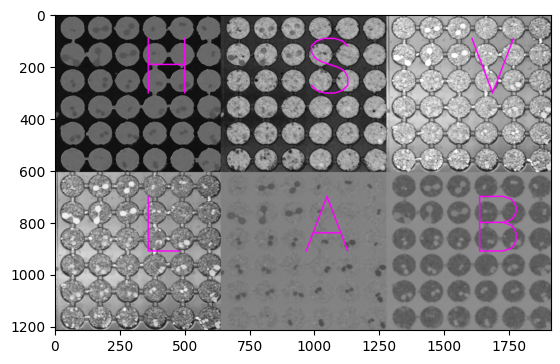

In [186]:



crop_img=img
colorspaces = pcv.visualize.colorspaces(rgb_img=crop_img, original_img=False)


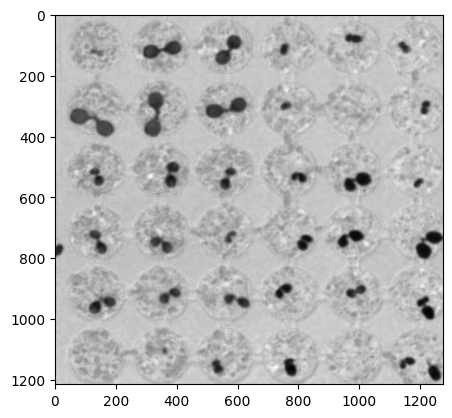

In [187]:
#Ignore this as well
# Convert the color image to grayscale
## Converts the input color image into the LAB colorspace and returns the A (green-magenta) channel as a grayscale image.

# Inputs:
#   rbg_img = original image
#   channel = desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img=crop_img, channel='a')#replace lab with hsv for hsv color pixels

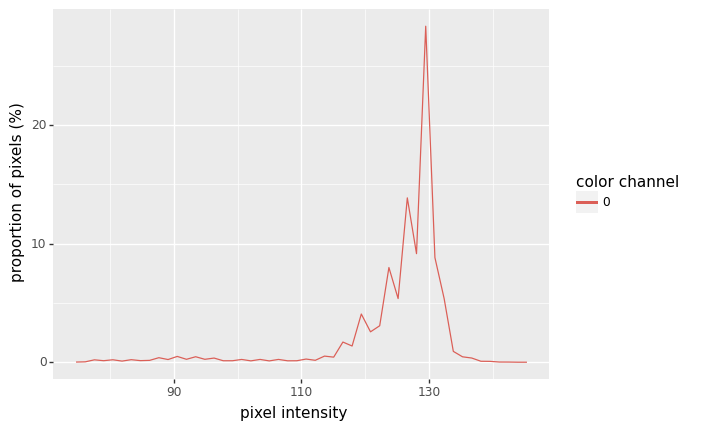

In [188]:
# Visualize the distribution of grayscale values
## A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the 
## selection of a threshold value.

## For this image, the large peak between 100-140 are from the brighter background pixels. 
## The smaller peak between 80-90 are the darker plant pixels.

# Inputs:
#   img         = a color or grayscale image
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a, bins=50)

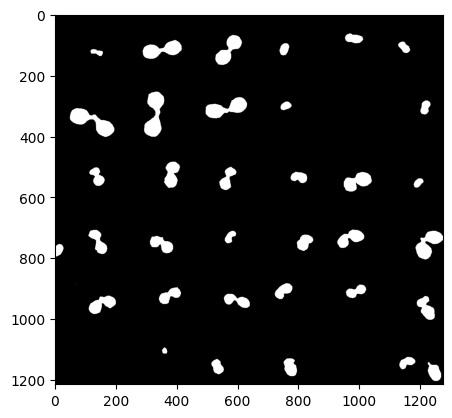

In [189]:
# Threshold the grayscale image
## Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and 
## background (black) pixels. Using the histogram above, a threshold point between 90-110 will segment the plant 
## and background peaks. Because the plants are the darker pixels in this image, use object_type="dark" to do an inverse threshold.

thresh_img = pcv.threshold.binary(gray_img=a, threshold= 110, max_value=135, object_type='dark')

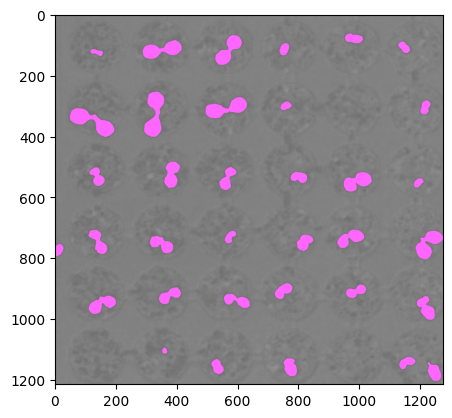

In [190]:
# Section 3: Measure Individual Plants
## Need a completed binary mask

# Identify the outlines of all plants
## The binary mask (all values are either white or black) that resulted from thresholding and filtering 
## the thresholded image is used to identify the polygons that define the outlines of every connected white region. 
## Objects (or contours) can be nested, so a hierarchy that defines the relationship between objects is also calculated.

# Inputs:
#   img  = input image
#   mask = a binary mask used to detect objects
obj, obj_hierarchy = pcv.find_objects(img=a, mask=thresh_img)#use the original image for img input

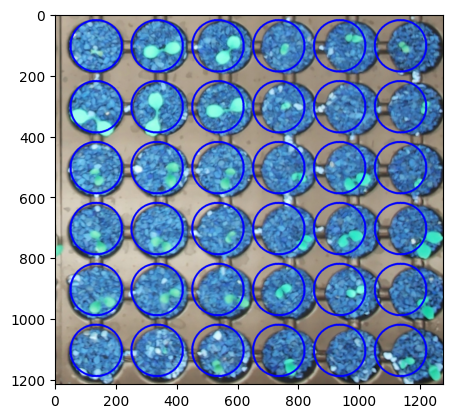

In [191]:
# Define a region of interest(ROI) for each plant by a grid
## Use the multi-ROI tool to define a region of interest (ROI) for each pot in the tray. 
## Each ROI will be associated with a plant later. The ROIs do not need to completely contain 
## a whole plant but must only overlap a single plant each.

# Inputs:
#   img     = input image
#   coord   = top left coordinate to begin the ROI grid
#   radius  = radius for each ROI
#   spacing = spacing between each ROI
#   nrows   = number of rows in the ROI grid
#   ncols   = number of columns in the ROI grid
#rois, roi_hierarchy = pcv.roi.multi(img=crop_img, coord=(231,285), radius=22, 
                                     #spacing=(65, 60), nrows=3, ncols=4)
pcv.params.line_thickness == 2
rois, roi_hierarchy = pcv.roi.multi(img=crop_img, coord=(135,104), radius=85, 
                                     spacing=(200, 200), nrows=6, ncols=6)

In [192]:
# Create a unique ID for each plant
## Create a sequence of values to label each plant within the image based on the ROI IDs.

# Inputs:
#   start = beginning value for range
#   stop  = ending value for range (exclusive)
plant_ids = range(0, len(rois))

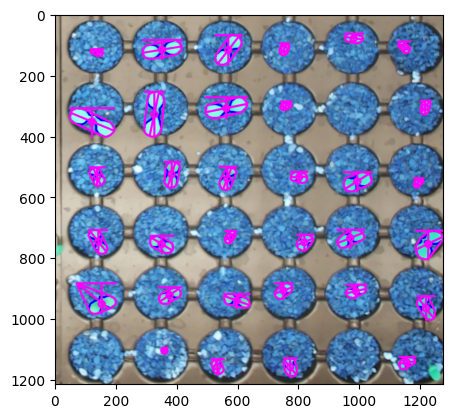

The number of plants in this image:  33
Germination rate:  91.66666666666666 %


In [193]:
# Create a copy of the original image for annotations

# Inputs:
#   img = original image
img_copy = np.copy(img)

# Set debug to None (plotting all of the images would be very verbose output)
pcv.params.debug = None
n=0#this will help with counting
# Create a for loop to interate through every ROI (plant) in the image
for i in range(0, len(rois)):
    # The ith ROI, ROI hierarchy, and plant ID
    roi = rois[i]
    hierarchy = roi_hierarchy[i]
    plant_id = plant_ids[i]
    

    #contours = object_contours[i]
  
    # Subset objects that overlap the ROI
    # Inputs:
    #   img            = input image
    #   roi_contour    = a single ROI contour
    #   roi_hierarchy  = a single ROI hierarchy
    #   object_contour = all objects detected in a binary mask
    #   obj_hierarchy  = all object hierarchies
    #   roi_type       = "partial" (default) keeps contours that overlap
    #                    or are contained in the ROI. "cutto" cuts off
    #                    contours that fall outside the ROI. "largest"
    #                    only keeps the largest object within the ROI
    plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=img, 
                                                                  roi_contour=roi, 
                                                                  roi_hierarchy=hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")
    
#     # Segment image with watershed function
#     watershed_header, watershed_data, analysis_images = pcv.watershed_segmentation(img, plant_mask)

#     print(watershed_header)
#     print(watershed_data)

    # If the plant area is zero then no plant was detected for the ROI
    # and no measurements can be done
    
    if area > 0:
        # Combine contours together for each plant
        # Inputs:
        #   img       = input image
        #   contours  = contours that will be consolidated into a single object
        #   hierarchy = the relationship between contours
        
        
        plant_obj, plant_mask = pcv.object_composition(img=img, 
                                                       contours=plant_contours, 
                                                       hierarchy=plant_hierarchy)
    
        n=n+1 #only counting objects (plants) that made the cut
        
        # Analyze the shape of each plant
        # Inputs:
        #   img   = input image
        #   obj   = composed object contours
        #   mask  = binary mask that contours were derived from
        #   label = a label for the group of measurements (default = "default")
   

        img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant{plant_id}")
    else:
        pass
        
#calculation of germination rate
germination_rate = (n/len(rois))*100 #we can also replace rois with 12 since we know the number
pcv.plot_image(img_copy)

number_of_plants_in_image=n
#print(len(obj))

print ("The number of plants in this image: ", str(number_of_plants_in_image))
print("Germination rate: ", str(germination_rate),"%")

In [194]:
#This has not worked.       
# Add a method to clear measurements
# def clear(self):
#     self.measurements = {"solidity"=False}
#     #self.images = []
# #     self.observations = {solidity=False}
# self.observations[sample][variable] = {
#             "trait": trait,
#             "method": method,
#             "scale": scale,
#             "datatype": str(datatype),
#             "value": value,
#             "label": label
#         }


# Add a new result inside of the csv file

## Use the method add_observation. Check the documentation
## dd_observation(sample, variable, trait, method, scale, datatype, value, label): Add new measurement or other information

pcv.outputs.add_observation(sample='default', variable='total_seeds', 
                            trait='total amound of seeds sowed',
                            method='ratio of pixels', scale='percent', datatype=int,
                            value=len(rois), label='# seeds')
pcv.outputs.add_observation(sample='default', variable='germination rate', 
                            trait='seeds germinated per tray',
                            method='ratio of pixels', scale='percent', datatype=int,
                            value=germination_rate, label='% germination')

pcv.outputs.add_observation(sample='default', variable='num_seeds', 
                            trait='seeds germinated per tray',
                            method='ratio of pixels', scale='percent', datatype=int,
                            value=number_of_plants_in_image, label='seeds germ')

In [195]:
# Save the results
## During analysis, measurements are stored in the background in the outputs recorder.

## This example includes image analysis for 'area', 'convex_hull_area', 'solidity', 'perimeter', 
## 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 
## 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity' using anayze_object.

## If other functions, for example color analysis, are desired, these should be included in the for loop.

## Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format
#                                   or "csv" tabular format
# pcv.print_image(filename="./Trials/imgs/a", img=img_copy)
def print_image(img, filename):
    image_type = type(img)
    if image_type == numpy.ndarray:
        cv2.imwrite(filename, img)
pcv.print_image(img_copy, os.path.join(args.outdir, filename + "_an.jpg"))
pcv.outputs.save_results(filename=args.result, outformat="csv")


#Another method to try
# image_type = type(img)
# #if image_type == numpy:
# pcv.print_image(filename, img)
#img errors from cv2
# ~\Anaconda3\lib\site-packages\plantcv\plantcv\print_image.py:23, in print_image(img, filename)
#      21 image_type = type(img)
#      22 if image_type == numpy.ndarray:
# ---> 23     cv2.imwrite(filename, img)
#      25 # Print matplotlib type images

#from plantcv 
# pcv.print_image(img, filename=)
# img.save(filename, verbose=False)